In [1]:
!pip install --upgrade wandb
!wandb login db0feaff82747014049595bbe7fa6495443366e6

Requirement already up-to-date: wandb in /opt/conda/lib/python3.6/site-packages (0.8.9)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import hamiltonians as H
import utils
from scipy.linalg import eigh
import wandb

%matplotlib inline

#### Setup

In [3]:
# use nvidia gpu if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
# only float32 tested
dtype = torch.double
    
print("Device:", device)
print("Data type:", dtype)

Device: cuda
Data type: torch.float64


#### setup problem

In [4]:
# Hamiltonian Setup
N=4000
N_proj=20
g=100
alpha=30
lr=0.1

In [5]:
%time Hgen = H.H_ring_2particles(N, g, device, dtype)

CPU times: user 1.91 s, sys: 905 ms, total: 2.81 s
Wall time: 2.81 s


In [6]:
# the hamiltonian model
model = utils.Hamiltonian(Hgen, N, N_proj).type(dtype).to(device)
model.train()

Hamiltonian(
  (decoder): Sequential(
    (matmul): Linear(in_features=20, out_features=4000, bias=False)
    (normalize): L2Norm()
  )
)

### Setup WandB logging

In [7]:
args = {
    "device": device.type, 
    "dtype": str(dtype),
    "N": N,
    "N_proj": N_proj,
    "g": g,
    "alpha": alpha,
    "lr": lr
}

In [8]:
wandb.init(project="manifold-learning", config=args)
wandb.watch(model)

In [9]:
# a function for logging in the optimization loop
def wandb_log(loss, loss_h, loss_i,step):
    wandb.log({
        'running_loss': loss,
        'running_loss_hamil': loss_h,
        'running_loss_ident': loss_i
    },
    step=step)

### solve

In [10]:
# loss function and optimizer
criterion = utils.Cost(N_proj, alpha).type(dtype).to(device)
optimizer = utils.optim.Rprop(model.parameters(), lr=lr)

In [11]:
# optimization
n_iter=8000
n_print=50
its, errs, hps, ips, ts = utils.optimize(model, optimizer, criterion, n_iter, n_print, wandb_log, stop_early=True, rel_tol=0.000001, patience=3, show_progress=True)

[50] loss: 189867685092.23211670 (189867685092.196899/0.035243). diff: 0.00000000. time: 1.5948
[100] loss: 0.29507610 (0.262744/0.032332). diff: -9493384254596.85156250. time: 1.7304
[150] loss: 0.23446687 (0.233144/0.001323). diff: -3.03046168. time: 1.8658
[200] loss: 0.22790410 (0.227897/0.000007). diff: -0.32813831. time: 2.0035
[250] loss: 0.22784999 (0.227849/0.000001). diff: -0.00270540. time: 2.1350
[300] loss: 0.22784192 (0.227842/0.000000). diff: -0.00040386. time: 2.2701
[350] loss: 0.22783800 (0.227838/0.000000). diff: -0.00019592. time: 2.4099
[400] loss: 0.22783550 (0.227835/0.000000). diff: -0.00012467. time: 2.5438
[450] loss: 0.22783394 (0.227834/0.000000). diff: -0.00007830. time: 2.6805
[500] loss: 0.22783284 (0.227833/0.000000). diff: -0.00005506. time: 2.8213
[550] loss: 0.22783191 (0.227832/0.000000). diff: -0.00004653. time: 2.9541
[600] loss: 0.22783120 (0.227831/0.000000). diff: -0.00003527. time: 3.0862
[650] loss: 0.22783062 (0.227831/0.000000). diff: -0.000

In [ ]:
%time eigs_t = torch.symeig(Hgen.type(torch.float64), eigenvectors=False).eigenvalues[:N_proj].cpu().numpy()
eigs_t

In [ ]:
%time eigs_sp = eigh(Hgen.type(torch.float64).cpu().numpy())[0][:N_proj]
eigs_sp

In [ ]:
eigs_approx = eigh(hps[-1].cpu().detach().numpy())[0][:N_proj]
eigs_approx

In [ ]:
utils.plot_rel_err(eigs_sp, eigs_approx)
utils.plot_rel_err(eigs_t, eigs_approx)

In [19]:
vecs = model.eval().decoder(model.eye).detach().cpu()
vecs.shape

torch.Size([20, 4000])

In [20]:
(vecs[0,:]**2).sum()

tensor(1.0000, dtype=torch.float64)

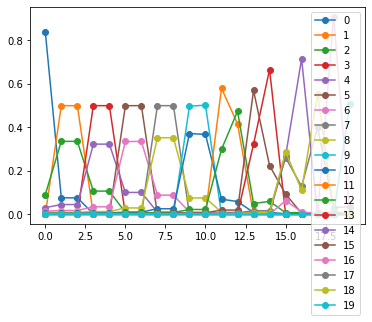

In [21]:
for i in range(0,20):
    plt.plot(vecs[i,:N_proj]**2,'o-',label=i);
plt.legend()

In [ ]:
# # hproj progress
# vmax=np.max(eigs_sp)
# vmin=0
# for it, hp in zip(its,hps):
#     Hplt = hp.cpu().detach().numpy()
#     plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)
#     plt.title("iter: %i" % (it+1))
#     plt.colorbar()
#     plt.show()

#### Animation

In [19]:
n_iter=500
n_print=1
its, errs, hps, ips, ts = utils.optimize(model, optimizer, criterion, n_iter, n_print, stop_early=False, rel_tol=0.01, patience=3, show_progress=False)

Finished Training


MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


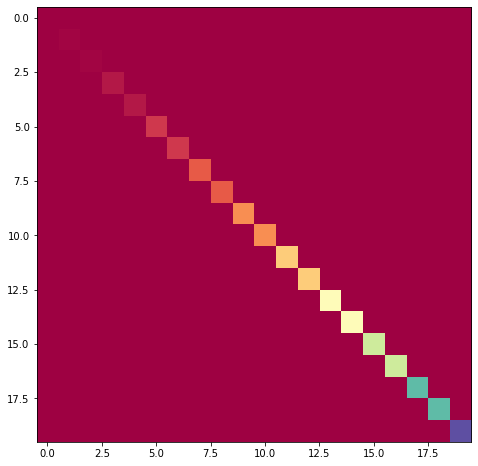

In [20]:
fig = plt.figure()
fig.set_size_inches(8,8, True)
ax = plt.axes()
vmax=np.max(eigs_sp)
vmin=0
Hplt = hps[0].cpu().detach().numpy()
mat = plt.imshow(np.abs(Hplt), origin="upper", cmap='Spectral', interpolation=None, vmax=vmax, vmin=vmin)


def init():
    mat.set_data(hps[0].cpu().detach().numpy())
    return mat,
def animate(i):
    hp = hps[i].cpu().detach().numpy()
    mat.set_data(hp)
    return mat,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(hps), interval=90, blit=True)

anim.save('diagonalization_H_ring_2particles.gif', writer='imagemagick')

#### Timing

In [40]:
# use cpu for timing due to massive gpu parallelization
# device = torch.device('cpu')
device

device(type='cuda')

In [53]:
Ns = np.logspace(3.333245,4.114,7).astype(int)
N_proj = 20
repeats = 7
alpha=20
max_iter = 10000
n_print = 200
rel_tol = 0.0001
criterion = utils.Cost(N_proj, alpha).type(dtype).to(device)

In [54]:
Ns

array([ 2153,  2906,  3921,  5292,  7140,  9635, 13001])

In [55]:
average_time = []
stddev_time = []
average_err = []
stddev_err = []
for N in Ns:
    t = []
    err = []
    for r in range(repeats):
        print("N=%i. Nproj=%i. repeat=%i" % (N, N_proj, r+1))
        Hgen = H.H_ring_2particles(N, g, device, dtype)
        model = utils.Hamiltonian(Hgen, N, N_proj).type(dtype).to(device)
        optimizer = utils.optim.Rprop(model.parameters(), lr=0.1)
        
        _, errs, _, _, ts = utils.optimize(model, optimizer, criterion, max_iter, n_print, show_progress=False, stop_early=True, rel_tol=rel_tol, patience=3)

        t.append(ts[-1])
        err.append(errs[-1])
        
    average_time.append(np.average(t))
    stddev_time.append(np.std(t))
    average_err.append(np.average(err))
    stddev_err.append(np.std(err))

N=2153. Nproj=20. repeat=1
Early stopping criteria met.
Finished Training
N=2153. Nproj=20. repeat=2
Early stopping criteria met.
Finished Training
N=2153. Nproj=20. repeat=3
Early stopping criteria met.
Finished Training
N=2153. Nproj=20. repeat=4
Early stopping criteria met.
Finished Training
N=2153. Nproj=20. repeat=5
Early stopping criteria met.
Finished Training
N=2153. Nproj=20. repeat=6
Early stopping criteria met.
Finished Training
N=2153. Nproj=20. repeat=7
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=1
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=2
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=3
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=4
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=5
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=6
Early stopping criteria met.
Finished Training
N=2906. Nproj=20. repeat=7
Early stopp

In [56]:
average_time= np.asarray(average_time)
stddev_time = np.asarray(stddev_time)
average_err= np.asarray(average_err)
stddev_err = np.asarray(stddev_err)

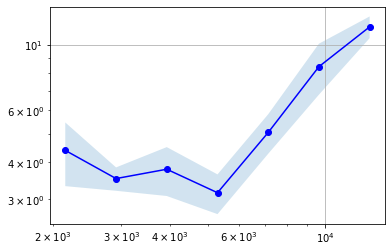

In [57]:
plt.loglog(Ns, average_time, 'bo-')
plt.fill_between(Ns, average_time-stddev_time, average_time+stddev_time, alpha=0.2)
plt.grid()

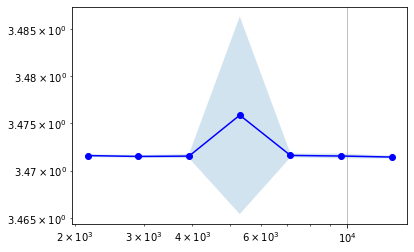

In [58]:
plt.loglog(Ns, average_err, 'bo-')
plt.fill_between(Ns, average_err-stddev_err, average_err+stddev_err, alpha=0.2)
plt.grid()

In [1]:
np.polyfit(np.log(Ns[-4:]), np.log(average_time[-4:]), 1)

NameError: name 'np' is not defined